COMP-6651 - Algorithm Design Techniques

Project - Clustering Algorithms Analysis

BIRCH Experimentation

Author - Sotirios Damas - 40317602

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans, Birch
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (calinski_harabasz_score, silhouette_score,
                             davies_bouldin_score, adjusted_rand_score,
                             normalized_mutual_info_score)
import kagglehub

In [ ]:
path_iris = kagglehub.dataset_download("himanshunakrani/iris-dataset")
f_path_iris = os.path.join(path_iris, 'iris.csv')
iris_df = pd.read_csv(f_path_iris)
# Extract labels (species)
iris_labels = iris_df['species']
# Remove label from the features
iris_features = iris_df.drop(columns=['species'])
# Convert to numpy
iris_data = iris_features.values


# Preprocessing for AI Global Index Dataset
def preprocess_ai_index(data):
    # Separate numerical and categorical columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    categorical_cols = data.select_dtypes(exclude=[np.number]).columns

    scaler = MinMaxScaler()
    num_scaled = scaler.fit_transform(data[numeric_cols]) if len(numeric_cols) > 0 else np.array([])

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_encoded = encoder.fit_transform(data[categorical_cols]) if len(categorical_cols) > 0 else np.array([])

    if num_scaled.size and cat_encoded.size:
        return np.hstack((num_scaled, cat_encoded))
    elif num_scaled.size:
        return num_scaled
    else:
        return cat_encoded

path_ai_index = kagglehub.dataset_download("katerynameleshenko/ai-index")
f_path_ai_index = os.path.join(path_ai_index, 'AI_index_db.csv')
ai_df = pd.read_csv(f_path_ai_index)
ai_df = ai_df.dropna()
# Extract the 'Cluster' column as the label
ai_labels = ai_df['Cluster']
# Remove the 'Cluster' column from the features
ai_df_features = ai_df.drop(columns=['Cluster'])
# Preprocess the remaining features
ai_data = preprocess_ai_index(ai_df_features)

path_earthquakes= kagglehub.dataset_download("shreyasur965/recent-earthquakes")
f_path_earthquakes = os.path.join(path_earthquakes, 'earthquakes.csv')
earthquake_df = pd.read_csv(f_path_earthquakes)
earthquake_df = earthquake_df[['magnitude', 'felt', 'cdi','mmi','tsunami','sig','depth', 'latitude', 'longitude', 'alert']].dropna()
# Extract the alert labels
earthquake_data_alerts = earthquake_df['alert']
alert_encoded = LabelEncoder().fit_transform(earthquake_data_alerts)
# Remove the label from features
earthquake_data_features = earthquake_df.drop(columns=['alert'])
# Scale the numeric features
earthquake_data = StandardScaler().fit_transform(earthquake_data_features)

In [ ]:
def compute_diameter(X, labels):
    """
    Computes the average 'diameter' across all clusters,
    where 'diameter' of a cluster is the maximum distance
    between any two points in that cluster.
    """
    from scipy.spatial.distance import pdist, squareform

    unique_labels = np.unique(labels)
    diameters = []
    for lbl in unique_labels:
        cluster_points = X[labels == lbl]
        if len(cluster_points) > 1:
            # pairwise distances in the cluster
            dist_matrix = squareform(pdist(cluster_points))
            diameters.append(dist_matrix.max())
        else:
            # A single point has diameter 0
            diameters.append(0.0)
    return np.mean(diameters)


def compute_split(X, labels):
    """
    An example 'split' metric: ratio of the size of the largest cluster
    to the size of the smallest cluster. If there's only one cluster, return 1.
    """
    unique_labels, counts = np.unique(labels, return_counts=True)
    if len(counts) < 2:
        return 1.0
    return counts.max() / counts.min()


def evaluate_clustering(X, labels, true_labels=None):
    """
    Compute a set of metrics for the given clustering labels.
    Some metrics require ground truth (true_labels).
    If no true_labels is provided, ARI and MI will be omitted.
    Returns a dict of metric_name -> value.
    """
    metrics_dict = {}

    # Unsupervised metrics
    metrics_dict["Silhouette"] = silhouette_score(X, labels)
    metrics_dict["Davies-Bouldin"] = davies_bouldin_score(X, labels)
    metrics_dict["Calinski-Harabasz"] = calinski_harabasz_score(X, labels)
    metrics_dict["Diameter"] = compute_diameter(X, labels)
    metrics_dict["Split"] = compute_split(X, labels)

    # If we have ground-truth labels, we can compute supervised metrics
    if true_labels is not None:
        metrics_dict["Adjusted Rand Index"] = adjusted_rand_score(true_labels, labels)
        # Using normalized_mutual_info_score as a measure of MI
        metrics_dict["Mutual Information"] = normalized_mutual_info_score(true_labels, labels)
    return metrics_dict


# Base BIRCH Implementation

In [ ]:
class CFCluster:
    def __init__(self, point):
        self.N = 1
        self.LS = np.array(point, dtype=float)
        self.SS = np.array(point, dtype=float) ** 2

    def centroid(self):
        return self.LS / self.N

    def variance(self):
        # Variance = (SS/N) - (centroid)^2 (elementwise), return mean variance
        return np.mean(self.SS / self.N - (self.centroid()) ** 2)

    def radius(self):
        # Approximate radius as sqrt(variance) (using average variance over dimensions)
        var = self.variance()
        return np.sqrt(np.maximum(var, 0))

    def diameter(self):
        # Diameter approximated as 2 * radius
        return 2 * self.radius()

    def add_point(self, point):
        self.N += 1
        self.LS += point
        self.SS += point ** 2

class CFTree:
    def __init__(self, threshold, B=float('inf')):
        self.threshold = threshold  # max allowed diameter
        self.B = B  # branching factor, not used in this simple version
        self.clusters = []  # list of CFClusters (leaf nodes)

    def insert(self, point):
        if not self.clusters:
            self.clusters.append(CFCluster(point))
            return

        # Find the cluster with closest centroid
        centroids = np.array([cluster.centroid() for cluster in self.clusters])
        distances = np.linalg.norm(centroids - point, axis=1)
        min_idx = np.argmin(distances)
        candidate = self.clusters[min_idx]

        # Temporarily add point
        candidate.add_point(point)
        # If diameter goes beyond threshold, revert & create new cluster
        if candidate.diameter() > self.threshold:
            # Undo addition: remove point from candidate (simplest: create a new cluster)
            candidate.N -= 1
            candidate.LS -= point
            candidate.SS -= point ** 2
            # Create a new cluster with the point
            self.clusters.append(CFCluster(point))
        # else: point added successfully

    def build_tree(self, data):
        for point in data:
            self.insert(point)
        return self.clusters

# Helper function to assign each point to the nearest centroid
def assign_clusters(data, centroids):
    labels = []
    for point in data:
        distances = np.linalg.norm(centroids - point, axis=1)
        labels.append(np.argmin(distances))
    return np.array(labels)

def final_cluster_labels(data, centroids, n_final_clusters):
    """
    Run KMeans on the CF tree centroids to merge them into n_final_clusters.
    Then, assign each original data point to the nearest final cluster center.
    """
    kmeans_final = KMeans(n_clusters=n_final_clusters, random_state=42, n_init=10)
    kmeans_final.fit(centroids)
    final_centroids = kmeans_final.cluster_centers_
    labels = assign_clusters(data, final_centroids)
    return labels, final_centroids

In [ ]:
def run_birch_experiment(name, X, threshold=0.5, final_n_clusters=None, true_labels=None):
    print(f"----- {name} -----")

    # Base BIRCH: build CF-tree
    cf_tree = CFTree(threshold=threshold)
    cf_clusters = cf_tree.build_tree(X)
    base_centroids = np.array([cluster.centroid() for cluster in cf_clusters])
    print("Base BIRCH: Number of CF clusters (micro-clusters):", len(base_centroids))

    # If final_n_clusters is provided, merge CF clusters with KMeans
    if final_n_clusters is not None and len(base_centroids) > final_n_clusters:
        labels_base, merged_centroids = final_cluster_labels(X, base_centroids, final_n_clusters)
        print(f"Base BIRCH (final clustering to {final_n_clusters} clusters):")
        print("Merged centroids shape:", merged_centroids.shape)
    else:
        labels_base = assign_clusters(X, base_centroids)


    # Sklearn Birch
    n_clusters_param = final_n_clusters if final_n_clusters is not None else None
    birch_model = Birch(threshold=threshold, n_clusters=n_clusters_param)
    birch_model.fit(X)
    sklearn_labels = birch_model.labels_

    # Compute evaluation metrics
    # If 'true_labels' is given, we can compute ARI, MI, etc.
    # Otherwise, those will be omitted.
    base_metrics = evaluate_clustering(X, labels_base, true_labels=true_labels)
    sklearn_metrics = evaluate_clustering(X, sklearn_labels, true_labels=true_labels)

    print("Base BIRCH Metrics:")
    for k, v in base_metrics.items():
        print(f"  {k}: {v:.4f}")

    print("Sklearn BIRCH Metrics:")
    for k, v in sklearn_metrics.items():
        print(f"  {k}: {v:.4f}")

    print("-"*40)
    return labels_base, sklearn_labels

In [ ]:
print("Running Base and Sklearn BIRCH on Iris Dataset")
base_labels_iris, sklearn_labels_iris = run_birch_experiment(
    "Iris", iris_data, threshold=0.5, final_n_clusters=3, true_labels=iris_labels
    )

print("Running Base and Sklearn BIRCH on AI Global Index Dataset")
base_labels_ai, sklearn_labels_ai = run_birch_experiment(
    "AI Global Index", ai_data, threshold=0.1, final_n_clusters=5, true_labels=ai_labels
    )

print("Running Base and Sklearn BIRCH on Earthquake Dataset")
base_labels_eq, sklearn_labels_eq = run_birch_experiment(
    "Earthquake", earthquake_data, threshold=0.5, final_n_clusters=4, true_labels=alert_encoded
    )

Running Base and Sklearn BIRCH on Iris Dataset
----- Iris -----
Base BIRCH: Number of CF clusters (micro-clusters): 13
Base BIRCH (final clustering to 3 clusters):
Merged centroids shape: (3, 4)
Base BIRCH Metrics:
  Silhouette: 0.5531
  Davies-Bouldin: 0.6594
  Calinski-Harabasz: 558.7773
  Diameter: 2.5281
  Split: 1.7027
  Adjusted Rand Index: 0.7173
  Mutual Information: 0.7507
Sklearn BIRCH Metrics:
  Silhouette: 0.5017
  Davies-Bouldin: 0.6263
  Calinski-Harabasz: 457.5418
  Diameter: 2.4998
  Split: 3.1667
  Adjusted Rand Index: 0.6096
  Mutual Information: 0.7051
----------------------------------------
Running Base and Sklearn BIRCH on AI Global Index Dataset
----- AI Global Index -----
Base BIRCH: Number of CF clusters (micro-clusters): 62
Base BIRCH (final clustering to 5 clusters):
Merged centroids shape: (5, 82)
Base BIRCH Metrics:
  Silhouette: 0.1848
  Davies-Bouldin: 1.6109
  Calinski-Harabasz: 10.1389
  Diameter: 2.7197
  Split: 5.4000
  Adjusted Rand Index: 0.0016
  M

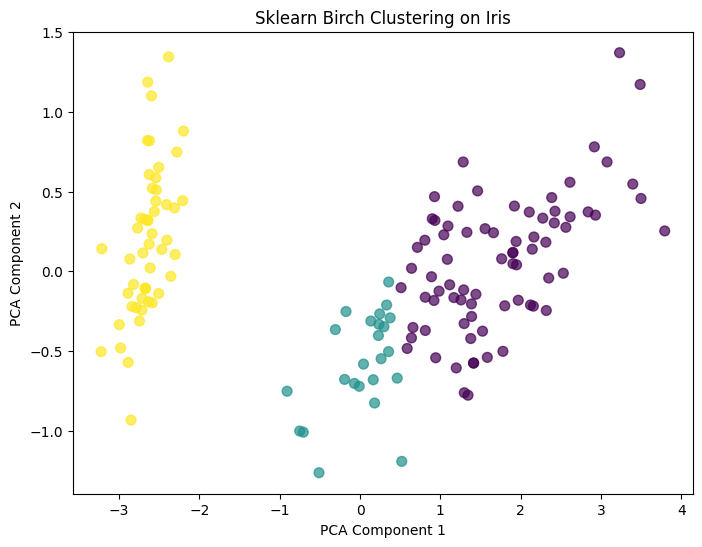

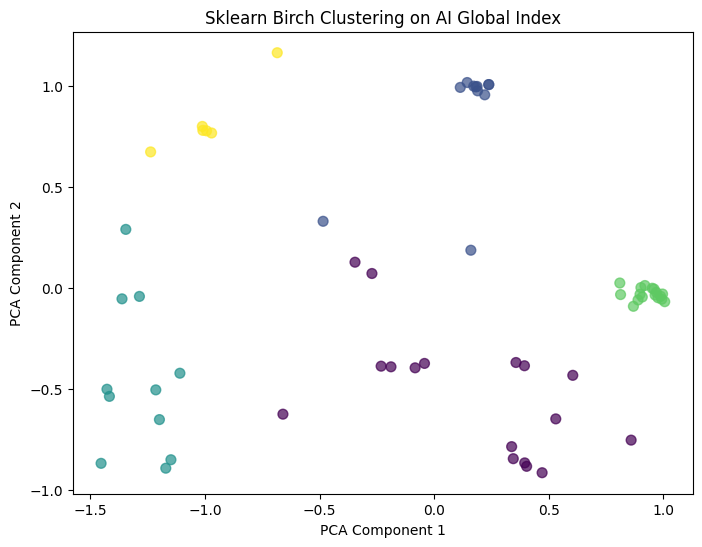

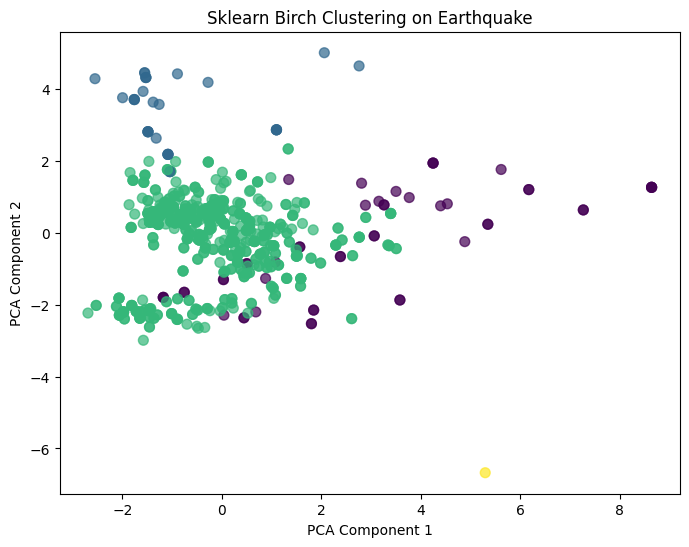

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_clusters(X, labels, title="Cluster Visualization", true_labels=None):
    """
    Reduces data to 2 dimensions using PCA and plots a scatter plot of the clusters.

    Parameters:
      X : array-like, shape (n_samples, n_features)
         The data matrix.
      labels : array-like, shape (n_samples,)
         Cluster labels to color the points.
      title : str
         Title for the plot.
      true_labels : array-like, optional
         True labels for comparison (will create an additional plot).
    """
    # Reduce data to 2 dimensions
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # Plot clustering result
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    #plt.colorbar(scatter, label="Cluster Label")
    plt.show()

    # If true labels are provided, plot them for comparison
    if true_labels is not None:
        plt.figure(figsize=(8,6))
        scatter_true = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=true_labels, cmap='viridis', s=50, alpha=0.7)
        plt.title(title + " (True Labels)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.colorbar(scatter_true, label="True Label")
        plt.show()


visualize_clusters(iris_data, sklearn_labels_iris, title="Sklearn Birch Clustering on Iris")

visualize_clusters(ai_data, sklearn_labels_ai, title="Sklearn Birch Clustering on AI Global Index")

visualize_clusters(earthquake_data, sklearn_labels_eq, title="Sklearn Birch Clustering on Earthquake")


In [ ]:
def select_top_k_features_for_alert(df, alert_col='alert', k=5):
    """
    Filters features based on Mutual Information (MI) with the alert label.
    Steps:
      1) Drop rows with any missing values (to avoid errors).
      2) Label-encode the alert column if it is categorical (e.g., text).
      3) For each feature, compute MI against the alert.
      4) Sort features by MI score, descending.
      5) Return the top k feature names.

    """
    data = df.dropna()

    # Separate the target (alert) from the features
    y = data[alert_col]
    X_df = data.drop(columns=[alert_col])

    # encode alert:
    y_enc = LabelEncoder().fit_transform(y)

    # mutual_info_classif calculates MI between each column and y_enc
    mi_scores = mutual_info_classif(X_df.values, y_enc, discrete_features=False)

    # Pair up (feature_name, mi_score)
    feats_and_scores = list(zip(X_df.columns, mi_scores))

    # Sort by MI descending
    feats_and_scores.sort(key=lambda x: x[1], reverse=True)

    # Pick top k
    top_features = [f[0] for f in feats_and_scores[:k]]

    return top_features

## 4.2 - Select the top 5 features for predicting alert

In [ ]:
top5_features = select_top_k_features_for_alert(
    earthquake_df,  # the original DataFrame with 'alert' and other columns
    alert_col='alert',
    k=5
)
print("Top 5 features most predictive of 'alert':", top5_features)

Top 5 features most predictive of 'alert': ['sig', 'mmi', 'longitude', 'latitude', 'magnitude']


## 4.3 - Re-run the clustering using only top-5 features

In [ ]:
# Subset the DataFrame to those top-5 columns
earthquake_df_top5 = earthquake_df[top5_features]

# 2) Scale the new subset
eq_top5_data = StandardScaler().fit_transform(earthquake_df_top5.values)

print("Running Base/Sklearn BIRCH on Earthquake Dataset with Top-5 Features")
_ = run_birch_experiment(
    "Earthquake (Top-5 Features)",
    eq_top5_data,
    threshold=0.5,
    final_n_clusters=4,
    true_labels=alert_encoded
)


Running Base/Sklearn BIRCH on Earthquake Dataset with Top-5 Features
----- Earthquake (Top-5 Features) -----
Base BIRCH: Number of CF clusters (micro-clusters): 67
Base BIRCH (final clustering to 4 clusters):
Merged centroids shape: (4, 5)
Base BIRCH Metrics:
  Silhouette: 0.4169
  Davies-Bouldin: 0.8756
  Calinski-Harabasz: 316.1290
  Diameter: 5.3576
  Split: 40.7500
  Adjusted Rand Index: 0.0080
  Mutual Information: 0.1302
Sklearn BIRCH Metrics:
  Silhouette: 0.3355
  Davies-Bouldin: 1.0412
  Calinski-Harabasz: 208.6165
  Diameter: 4.7277
  Split: 61.7778
  Adjusted Rand Index: 0.1927
  Mutual Information: 0.2512
----------------------------------------
